In [150]:
import requests
from bs4 import BeautifulSoup
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

import pandas as pd
from urllib.parse import quote
from tqdm.notebook import tqdm
import folium, json

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
url = 'https://search.danawa.com/dsearch.php?k1=%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0&module=goods&act=dispMain'

In [4]:
driver = webdriver.Chrome()
url = 'https://search.danawa.com/dsearch.php?k1=%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0&module=goods&act=dispMain'
driver.get(url)
time.sleep(2)
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [5]:
soup

<html class="js no-touch" lang="ko" xml:lang="ko" xmlns="http://www.w3.org/1999/xhtml"><head>
<title>무선청소기 : 다나와 통합검색</title>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><meta content="IE=Edge" http-equiv="X-UA-Compatible"/><meta content="무선청소기 통합검색 : 다나와 통합검색" name="title"/>
<meta content="'무선청소기'의 다나와 통합검색 결과입니다." name="description"/>
<meta content="무선청소기, 다나와, 최저가, 가격비교, 검색, 통합검색, 차이슨 무선청소기, 샤오미 무선청소기, 일렉트로룩스 무선청소기, 디베아 무선청소기, 삼성 무선청소기, 아이닉 무선청소기 new i20, lg 무선청소기, 다이슨 무선청소기, 무선청소기 캐치웰 cx pro, 차량용 무선청소기" name="keywords"/>
<meta content="무선청소기 통합검색 : 다나와 통합검색" property="og:title"/>
<meta content="'무선청소기'의 다나와 통합검색 결과입니다." property="og:description"/>
<meta content="https://img.danawa.com/new/tour/img/logo/sns_danawa.jpg" property="og:image"/>
<meta content="width=1280" name="viewport"/>
<link href="//img.danawa.com/new/danawa_main/v1/img/danawa_favicon.ico" rel="shortcut icon"/>
<link href="//static.danawa.com/css/common.css?v=2304171200" rel="stylesheet" type=

In [6]:
prod_items = soup.select('li.prod_item')
len(prod_items)

43

In [7]:
title = prod_items[0].select('p.prod_name > a')
title

[<a class="click_log_product_standard_title_" href="https://prod.danawa.com/info/?pcode=14574131&amp;keyword=%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0&amp;cate=14237761" onmousedown="_trkEventLog('통합검색_상품블로그_유입'); doCTR('%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0','14574131',1);" target="_blank">베이스어스 차량용 <b>청소기</b> A3 (해외구매)</a>]

In [8]:
spec_list = prod_items[0].select('div.spec_list')[0].text.replace('\t', '').replace("\n", "")
spec_list

'차량용청소기 / 무선 / 흡입력: 15,000Pa / 최대출력: 135W / 헤파필터 / 추가노즐: 틈새, 솔브러쉬 / LED라이트 / 사용시간: 45분 / 배터리 잔량표시 / 소음: 75dB / 충전방식: USB C타입 / 충전시간: 3~5시간 / 색상: 블랙, 실버 / 크기: 296x56.5mm'

In [9]:
price = prod_items[0].select('li.rank_one > p.price_sect > a > strong')[0].text.strip()
price

'46,950'

In [10]:
# 상품 정보 태그에서 원하는 정보를 추출하는 함수
def get_prod_items(prod_items):
    prod_data = []
    for prod_item in prod_items:
        if 'ad_nvista' in prod_item.select_one('div')['class']:
            continue
        try:
            title = prod_item.select('p.prod_name > a')
            spec_list = prod_item.select('div.spec_list')[0].text.replace('\t', '').replace("\n", "")
            price = prod_item.select('li.rank_one > p.price_sect > a > strong')[0].text.strip()
            prod_data.append([title, spec_list, price])
        except:
            pass
    return prod_data

In [11]:
prod_data = get_prod_items(prod_items)
len(prod_data)

40

# 2.여러페이지에 걸친 다나와 검색 페이지 크롤링

In [12]:
def get_search_page_url(keyword, page):
    return 'https://search.danawa.com/dsearch.php?query={}&volumeType=allvs&page={}&limit=40&sort=saveDESC&list=list&boost=true&addDelivery=N&mode=simple&recommendedSort=Y&defaultUICategoryCode=14237761&defaultPhysicsCategoryCode=1840%7C59152%7C59189%7C0&defaultVmTab=3014&defaultVaTab=970283&tab=main'.format(keyword, page)
    

In [13]:
keyword = '무선청소기'
page = 10
url = get_search_page_url(keyword, page)
print(url)

https://search.danawa.com/dsearch.php?query=무선청소기&volumeType=allvs&page=10&limit=40&sort=saveDESC&list=list&boost=true&addDelivery=N&mode=simple&recommendedSort=Y&defaultUICategoryCode=14237761&defaultPhysicsCategoryCode=1840%7C59152%7C59189%7C0&defaultVmTab=3014&defaultVaTab=970283&tab=main


In [14]:
# 전체 페이지 코드정리
keyword = '무선청소기'
total_page = 10
prod_data_total = []
for page in tqdm(range(1, total_page+1)):
    url = get_search_page_url(keyword, page)
    driver.get(url)
    time.sleep(2)
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 상품정보 추출
    prod_items = soup.select('li.prod_item')
    prod_item_list = get_prod_items(prod_items)
    
    #추출한 정보 저장
    prod_data_total += prod_item_list

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
df = pd.DataFrame(prod_data_total, columns = ['상품명', '스펙목록', '가격'])
df

,상품명,스펙목록,가격
0,"[[베이스어스 차량용 , [청소기], A3 (해외구매)]]","차량용청소기 / 무선 / 흡입력: 15,000Pa / 최대출력: 135W / 헤파필...","46,950"
1,[[LG전자 오브제컬렉션 코드제로 A9S AU9982]],핸디스틱청소기 / 무선형 / 흡입+물걸레겸용 / 흡입력: 220W / [구성] 와이...,"1,019,090"
2,"[[샤오미 미지아 차량용 핸디 , [무선], , [청소기], (해외구매)]]","차량용청소기 / 무선 / 흡입력: 13,000Pa / 최대출력: 120W / 헤파필...","38,990"
3,[[LG전자 오브제컬렉션 코드제로 A9S AU9882]],핸디스틱청소기 / 무선형 / 흡입+물걸레겸용 / 흡입력: 220W / [구성] 와이...,"894,400"
4,"[[아이오랩 아이클린 , [무선], 미니 핸디 , [청소기]]]","차량용청소기 / 무선 / 흡입력: 10,000Pa / 최대출력: 65W / 헤파필터...","59,200"
...,...,...,...
395,[[일렉트로룩스 퓨어 Q9 PQ91-3BW]],핸디스틱청소기 / 무선형 / 흡입전용 / [구성] 바닥 / 침구 / 솔형 / 더스팅...,"315,340"
396,[[캐치웰 CX11 PLUS]],핸디스틱청소기 / 무선형 / 흡입전용 / 흡입력: 20000Pa / [구성] 바닥 ...,"144,690"
397,[[다이슨 디지털 슬림]],핸디스틱청소기 / 무선형 / 흡입전용 / 흡입력: 100AW / [구성] 슬림소프트...,"610,540"
398,"[[아우라 몬스터 , [무선], 진공 , [청소기], AURA-V5300]]","차량용청소기 / 무선 / 흡입력: 5,300Pa / 최대출력: 50W / 헤파필터 ...","58,960"


In [16]:
df.to_csv('danawa_crawling_result.csv', index=False)

# 회사명, 상품명 분리

In [17]:
company_list = []
product_list = []
for i in range(len(df)):
    company_list.append(df['상품명'][i][0].get_text().split()[0])
    product_list.append(df['상품명'][i][0].get_text().split(' ', 1))

# print(product_list)

In [18]:
len(df)

400

In [19]:
# df['상품명'][4][0].get_text().split()[1:].join()

In [20]:
df['상품명'][4][0].get_text().split(' ', 1)

['아이오랩', '아이클린 무선 미니 핸디 청소기']

In [21]:
# solution
# company_list2 = []
# product_list2 = []
# for title in df['상품명']:
#     print(title)
#     title_info = title.split(' ', 1)
#     company_name = title_info[0]
#     product_name = title_info[1]
#     company_list2.append(company_name)
#     product_list2.append(product_name)

# 스펙 목록에서 카테고리 사용시간 흡입력 추출

In [22]:
spec_list = df['스펙목록'][0].split(' / ')
spec_list

['차량용청소기',
 '무선',
 '흡입력: 15,000Pa',
 '최대출력: 135W',
 '헤파필터',
 '추가노즐: 틈새, 솔브러쉬',
 'LED라이트',
 '사용시간: 45분',
 '배터리 잔량표시',
 '소음: 75dB',
 '충전방식: USB C타입',
 '충전시간: 3~5시간',
 '색상: 블랙, 실버',
 '크기: 296x56.5mm']

In [23]:
# 카테고리 정보 추출
category = spec_list[0]
category

'차량용청소기'

In [24]:
for spec in spec_list:
    if '사용시간' in spec:
        use_time_spec = spec
    elif '흡입력' in spec:
        suction_spec = spec
        
print(use_time_spec)
print(suction_spec)

사용시간: 45분
흡입력: 15,000Pa


In [25]:
use_time_value = use_time_spec.split(' ')[1].strip()
use_time_value

'45분'

In [26]:
suction_value = suction_spec.split(' ')[1].strip()
suction_value

'15,000Pa'

In [27]:
# 카테고리, 사용시간, 흡입력
category_list = []
use_time_list = []
suction_list = []
for spec_data in df['스펙목록']:
    spec_list = spec_data.split(' / ')
    category = spec_list[0]
    category_list.append(category)
    
    use_time_value = None
    suction_value = None
    for spec in spec_list:
        if '사용시간' in spec:
#             print(spec)
            use_time_value = spec.split(' ')[1].strip()
        elif '흡입력' in spec:
#             print(spec.split(':')[1])
            suction_value = spec.split(':')[1].strip()    
            print(suction_value)
    use_time_list.append(use_time_value)
    suction_list.append(suction_value)

15,000Pa
220W
13,000Pa
220W
10,000Pa
210W
200W
210W
220W
210W
16,800Pa
150AW
25000Pa
13,000Pa
200W
220W
210W
220W
30000Pa
220W
12,000Pa
35000Pa
150AW
200W
15,000Pa
150AW
200W
210W
150W
140AW
22000Pa
50AW
151AW
220W
5,000Pa
210W
16,000Pa
200W
185AW
262AW
40000Pa
15,000~Pa
6,000~15,000Pa
15,000Pa
220W
210W
210W
220W
210W
210W
5,000Pa
220W
12,000Pa
210W
6,500Pa
150AW
15,000Pa
12,000Pa
6,000Pa
150AW
25000Pa
8,000Pa
12,000Pa
150W
5,500Pa
220W
220W
17,000Pa
39000Pa
220W
220W
18000Pa
12,000Pa
30AW
15,000Pa
200W
210W
220W
220W
120W
220W
100AW
6,000Pa
370W
60W
13000Pa
150W
~12,000Pa
210W
20000Pa
280W
15000Pa
4,800Pa
8,000Pa
12000Pa
240AW
3,000~3,500Pa
10,000Pa
220W
6000Pa
8,000Pa
150W
5,000Pa
210W
200W
6500Pa
220W
2,000Pa
6000Pa
35AW
210W
6,600Pa
185AW
27000Pa
15,000Pa
10,000Pa
31000Pa
30W
20000Pa
180AW
39000Pa
150AW
25000Pa
5,200Pa
220W
5,000Pa
220W
5000Pa
200W
120AW
20000Pa
30AW
140AW
23000Pa
5,000Pa
280W
16,800Pa
12,000Pa
3500Pa
최대 9,000Pa
5,000Pa
15000Pa
6,000Pa
25000Pa
8000Pa
210W
4,500Pa


In [28]:
print('카테고리: ', len(category_list), category_list[0:5])
print('사용시간: ', len(use_time_list), use_time_list[0:5])
print('흡입력: ', len(suction_list), suction_list[0:5])

카테고리:  400 ['차량용청소기', '핸디스틱청소기', '차량용청소기', '핸디스틱청소기', '차량용청소기']
사용시간:  400 ['45분', '1시간', '9~30분', '1시간', '45분']
흡입력:  400 ['15,000Pa', '220W', '13,000Pa', '220W', '10,000Pa']


# 3. 무선청소기 사용시간 통일

In [29]:
use_time_list

['45분',
 '1시간',
 '9~30분',
 '1시간',
 '45분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '1시간',
 '30분',
 '1시간30분',
 '9~30분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '1시간',
 ':',
 '50분',
 '1시간',
 '1시간',
 '12분(고속),25분(저속)',
 '1시간5분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '20분',
 '3시간',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '32분',
 None,
 '1시간',
 '사용시간:',
 None,
 '1시간',
 None,
 '1시간10분',
 '40분',
 '25분',
 '18~50분',
 '15~28분',
 '1시간',
 '1시간',
 None,
 '53분',
 '1시간',
 '53분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '45분',
 '15분',
 '1시간',
 '48분',
 '3시간',
 '50분',
 '30분',
 '1시간',
 '20분',
 '15분',
 '40분',
 '25분',
 '~30분',
 '25분',
 '50분',
 '1시간10분',
 '20분',
 '17분',
 '50분',
 '15분',
 '20분',
 '1시간',
 '1시간',
 '1시간',
 '~30분',
 '48분',
 '1시간',
 '1시간',
 '1시간',
 '10분',
 '50분',
 '30분',
 '13분',
 '28분',
 '1시간',
 '45분',
 '45분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '40분',
 '35분',
 '1시간',
 '30분',
 '40분',
 '20분',
 '45분',
 '9분',
 '20분',
 '40분',
 None,
 '1시간',
 '50분',
 '1시간20분',
 '23분',
 '25분',
 '25~30분',
 '40분',
 '1시간',
 '20분',
 None

In [30]:
# while None in use_time_list:
#     # removing None from list using remove method
#     use_time_list.remove(None)
# use_time_list

In [31]:
# while '사용시간:' in use_time_list:
#     # removing '사용시간:' from list using remove method
#     use_time_list.remove('사용시간:')
# use_time_list

In [32]:
# while '분' in use_time_list:
#     # removing '사용시간:' from list using remove method
#     use_time_list.remove('분')
# use_time_list

In [33]:
new_time_list=[]
for time in use_time_list:
    if '시간' in time:
        new_time = int(time[0])*60
        if len(time) == 6:
            new_time += int(time[3:5])
        elif len(time) == 5:
            new_time += int(time[3:4])
            #print(time)
        new_time_list.append(new_time)
# new_time_list

TypeError: argument of type 'NoneType' is not iterable

In [34]:
def convert_time_minute2():
    new_time_list=[]
    for time in use_time_list:
        if '시간' in time:
            new_time = int(time[0])*60
            if len(time) == 6:
                new_time += int(time[3:5])
            elif len(time) == 5:
                new_time += int(time[3:4])
            new_time_list.append(new_time)
    return new_time_list

In [35]:
# convert_time_minute(use_time_list)

In [36]:
# solution
def convert_time_minute(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]  # 1시간20분 -> 1
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0] # 1시간 20분 -> 20분 -> 20
            else:
                minute = 0
        else:
            hour = 0
            minute = time.split('분')[0]
        return int(hour) * 60 + int(minute)
    except:
        return None

In [37]:
times = ['45분', '1시간', '9~30분', '1시간30분', '9분', '2시간20분']
for time in times:
    time_value = convert_time_minute(time)
    print(time, '=', time_value)

45분 = 45
1시간 = 60
9~30분 = None
1시간30분 = 90
9분 = 9
2시간20분 = 140


In [38]:
new_use_time_list = []
for time in use_time_list:
    value = convert_time_minute(time)
    new_use_time_list.append(value)
print(len(new_use_time_list))
print(new_use_time_list[:10])

400
[45, 60, None, 60, 45, 60, 60, 60, 60, 35]


# 흡입력 단위 통일

In [39]:
# remove w and pa -> pa/100
def get_suction(value):
    try:
        value = value.upper()
        if 'AW' in value or "W" in value:
            result = value.replace('A', '').replace("W", "")
            result = int(result.replace(',', ''))
        elif 'PA' in value:
            result = value.replace('PA', "")
            result = int(result.replace(',', ''))/100
        else:
            result = None
        return result
    except:
        return None 

In [40]:
# 흡입력 함수 동작 테스트
suc = ['15,000Pa', '200W', '13,000Pa', '220W', '210W']
for su in suc:
    suc_va = get_suction(su)
    print(suc_va)

150.0
200
130.0
220
210


In [41]:
new_suction_list = []
for power in suction_list:
    value = get_suction(power)
    new_suction_list.append(value)
print(len(new_suction_list))
print(new_suction_list)

400
[150.0, 220, 130.0, 220, 100.0, 210, 200, 210, 220, None, 210, 168.0, 250.0, 130.0, 200, 220, 210, None, 220, 300.0, 220, 120.0, 350.0, 150, 200, 150.0, 150, 200, 210, 150, 220.0, 50, None, 151, 220, 50.0, 210, 160.0, None, 200, None, None, 185, None, 262, 400.0, None, None, 150.0, 220, None, None, None, 210, None, 210, 220, 210, 210, None, 50.0, 220, None, None, None, 120.0, 210, 65.0, None, 150, 150.0, 120.0, 60.0, None, 250.0, 80.0, 120.0, 150, None, 55.0, 220, 220, None, 170.0, 390.0, 220, 220, None, None, 180.0, 120.0, 30, 150.0, 200, None, None, 210, None, 220, 220, 120, None, 220, None, 100, 60.0, 370, 60, 130.0, 150, None, 210, 200.0, 280, 150.0, 48.0, 80.0, 120.0, 240, None, 100.0, 220, 60.0, 80.0, 150, 50.0, 210, 200, 65.0, 220, 20.0, 60.0, 35, 210, None, 66.0, None, None, 270.0, 150.0, None, None, None, None, None, 100.0, 310.0, None, 30, None, 200.0, 390.0, 250.0, None, None, 52.0, None, 220, None, 50.0, None, 220, 50.0, None, 200, 200.0, None, None, 30, 230.0, None, 50

In [42]:
# save in excel
pd_data = pd.DataFrame()
pd_data['카테고리'] = category_list
pd_data['회사명'] = company_list
pd_data['제품'] = product_list
pd_data['가격'] = df['가격']
pd_data['사용시간'] = new_use_time_list
pd_data['흡입력'] = new_suction_list
pd_data.head()

,카테고리,회사명,제품,가격,사용시간,흡입력
0,차량용청소기,베이스어스,"[베이스어스, 차량용 청소기 A3 (해외구매)]","46,950",45.0,150.0
1,핸디스틱청소기,LG전자,"[LG전자, 오브제컬렉션 코드제로 A9S AU9982]","1,019,090",60.0,220.0
2,차량용청소기,샤오미,"[샤오미, 미지아 차량용 핸디 무선 청소기 (해외구매)]","38,990",NaN,130.0
3,핸디스틱청소기,LG전자,"[LG전자, 오브제컬렉션 코드제로 A9S AU9882]","894,400",60.0,220.0
4,차량용청소기,아이오랩,"[아이오랩, 아이클린 무선 미니 핸디 청소기]","59,200",45.0,100.0


In [43]:
pd_data.to_csv('result_preprocessing.csv', index = False)

In [44]:
pd_data['카테고리'].value_counts()

핸디스틱청소기             216
차량용청소기               93
핸디청소기                36
물걸레청소기               30
욕실청소기                 8
업소용청소기                6
스틱청소기                 5
핸디/스틱청소기+로봇청소기세트      3
침구청소기                 2
물걸레청소기+스팀청소기          1
Name: 카테고리, dtype: int64

In [45]:
pd_data_final = pd_data[pd_data['카테고리'].isin(['핸디스틱청소기'])]
pd_data_final

,카테고리,회사명,제품,가격,사용시간,흡입력
1,핸디스틱청소기,LG전자,"[LG전자, 오브제컬렉션 코드제로 A9S AU9982]","1,019,090",60.0,220.0
3,핸디스틱청소기,LG전자,"[LG전자, 오브제컬렉션 코드제로 A9S AU9882]","894,400",60.0,220.0
5,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 VS20A956A3]","492,110",60.0,210.0
6,핸디스틱청소기,LG전자,"[LG전자, 코드제로 A9S AS9200BA]","520,790",60.0,200.0
7,핸디스틱청소기,LG전자,"[LG전자, 오브제컬렉션 코드제로 A9S AO9571]","756,710",60.0,210.0
...,...,...,...,...,...,...
391,핸디스틱청소기,신일전자,"[신일전자, SVC-RK200WS]","108,000",22.0,NaN
395,핸디스틱청소기,일렉트로룩스,"[일렉트로룩스, 퓨어 Q9 PQ91-3BW]","315,340",55.0,NaN
396,핸디스틱청소기,캐치웰,"[캐치웰, CX11 PLUS]","144,690",60.0,200.0
397,핸디스틱청소기,다이슨,"[다이슨, 디지털 슬림]","610,540",40.0,100.0


In [46]:
pd_data_final['가격'].unique()

array(['1,019,090', '894,400', '492,110', '520,790', '756,710', '598,990',
       '183,500', '639,120', '183,710', '381,650', '525,990', '478,710',
       '556,960', '765,970', '169,000', '805,450', '269,000', '807,640',
       '394,740', '166,240', '643,750', '591,990', '378,900', '156,860',
       '446,160', '575,790', '785,570', '595,700', '165,690', '636,920',
       '663,910', '1,225,290', '197,490', '897,380', '299,000', '168,290',
       '234,100', '613,210', '309,150', '711,990', '1,177,940', '587,220',
       '743,820', '182,860', '545,990', '196,550', '615,670', '299,990',
       '312,540', '790,190', '1,185,700', '248,000', '703,860', '518,770',
       '482,460', '139,000', '349,000', '199,440', '221,790', '594,140',
       '368,110', '700,920', '899,180', '87,900', '583,840', '199,000',
       '76,100', '569,990', '179,000', '1,557,730', '46,650', '79,000',
       '1,135,180', '789,200', '745,550', '726,902', '695,090', '41,900',
       '668,870', '195,000', '217,500', '375

In [47]:
pd_data_final.to_csv('2_result_preprocessing.csv', index=False)

In [48]:
data = pd.read_csv('2_result_preprocessing.csv')

In [52]:
top_list = pd_data_final.sort_values(['흡입력'], ascending = False)
top_list.head()

,카테고리,회사명,제품,가격,사용시간,흡입력
45,핸디스틱청소기,DIBEA,"[DIBEA, 차이슨 ALLNEW22000 스노우화이트]","197,490",40.0,400.0
151,핸디스틱청소기,행커,"[행커, 400W]","170,100",60.0,390.0
84,핸디스틱청소기,DIBEA,"[DIBEA, 차이슨 ALLNEW29000]","248,000",48.0,390.0
106,핸디스틱청소기,에어메이드,"[에어메이드, 스마트포스 AMC-3500]","199,000",45.0,370.0
385,핸디스틱청소기,로헨,"[로헨, L30]","169,000",50.0,350.0


In [51]:
top_list2 = pd_data_final.sort_values(['사용시간'], ascending = False)
top_list2.head()

,카테고리,회사명,제품,가격,사용시간,흡입력
138,핸디스틱청소기,샤오미,"[샤오미, 드리미 V12]","375,967",90.0,270.0
12,핸디스틱청소기,샤오미,"[샤오미, 드리미 V11]","183,710",90.0,250.0
174,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS28C973DR]","1,499,990",80.0,280.0
233,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS25C972DR]","1,260,630",80.0,250.0
113,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS28C973ES]","1,557,730",80.0,280.0


In [56]:
top_list3 = pd_data_final.sort_values(['사용시간', '흡입력'], ascending = False)
top_list3.head(15)

,카테고리,회사명,제품,가격,사용시간,흡입력
138,핸디스틱청소기,샤오미,"[샤오미, 드리미 V12]","375,967",90.0,270.0
12,핸디스틱청소기,샤오미,"[샤오미, 드리미 V11]","183,710",90.0,250.0
113,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS28C973ES]","1,557,730",80.0,280.0
174,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS28C973DR]","1,499,990",80.0,280.0
276,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS28C973GSK]","1,579,990",80.0,280.0
233,핸디스틱청소기,삼성전자,"[삼성전자, 비스포크 제트 AI VS25C972DR]","1,260,630",80.0,250.0
231,핸디스틱청소기,샤오미,"[샤오미, 로이드미 X30 프로]","278,060",70.0,265.0
44,핸디스틱청소기,다이슨,"[다이슨, Gen5 디텍트™ 컴플리트]","1,225,290",70.0,262.0
74,핸디스틱청소기,샤오미,"[샤오미, 드리미 T20]","312,540",70.0,250.0
346,핸디스틱청소기,샤오미,"[샤오미, 지미 JV85 프로]","138,220",70.0,250.0


In [124]:
price_mean_value = pd_data_final['가격']

In [125]:
suction_mean_value.astype(float)
suction_mean_value = pd_data_final['흡입력'].mean()
use_time_mean_value = pd_data_final['사용시간'].mean()

In [126]:
type(price_mean_value) #.replace(',', '')  #.astype(int)

pandas.core.series.Series

In [127]:
price_mean_value = price_mean_value.str.replace(',', '')
price_mean_value

# df['my_column'] = df['my_column'].str.replace('this_string', '')

1      1019090
3       894400
5       492110
6       520790
7       756710
        ...   
391     108000
395     315340
396     144690
397     610540
399     107000
Name: 가격, Length: 216, dtype: object

In [128]:
price_mean_value = price_mean_value.astype(float)
price_mean_value

1      1019090.0
3       894400.0
5       492110.0
6       520790.0
7       756710.0
         ...    
391     108000.0
395     315340.0
396     144690.0
397     610540.0
399     107000.0
Name: 가격, Length: 216, dtype: float64

In [131]:
price_mean_value = price_mean_value.mean()# = pd_data_final['가격']#.mean()

suction_mean_value = pd_data_final['흡입력'].mean()
use_time_mean_value = pd_data_final['사용시간'].mean()
print('가격 평균: ', price_mean_value)
print('흡입력 평균: ', suction_mean_value)
print('사용시간 평균: ', use_time_mean_value)

가격 평균:  391826.7638888889
흡입력 평균:  202.37671232876713
사용시간 평균:  49.44117647058823


In [134]:
type(use_time_mean_value)

numpy.float64

In [135]:
type(suction_mean_value)

numpy.float64

In [137]:
type(price_mean_value)

numpy.float64

In [145]:
price_con = pd_data_final['가격']#.astype(float)
price_con = price_con.str.replace(',', '').astype(float)
price_con

1      1019090.0
3       894400.0
5       492110.0
6       520790.0
7       756710.0
         ...    
391     108000.0
395     315340.0
396     144690.0
397     610540.0
399     107000.0
Name: 가격, Length: 216, dtype: float64

In [152]:
# 가성비 좋은 제품 선택
# 가격이 평균이 하고, 흡입력, 사용시간이 평균보다 높으면
# 조건 = (pd_data_final['가격'] <= price_mean_value) & 
# (pd_data_final['흡입력'] >= suction_mean_value) & (pd_data_final['사용시간'] >= use_time_mean_value)
condition_data = pd_data_final[(price_con <= price_mean_value) & (pd_data_final['흡입력'] >= suction_mean_value) & (pd_data_final['사용시간'] >= use_time_mean_value)]
condition_data

,카테고리,회사명,제품,가격,사용시간,흡입력
12,핸디스틱청소기,샤오미,"[샤오미, 드리미 V11]","183,710",90.0,250.0
19,핸디스틱청소기,아이닉,"[아이닉, NEW i20]","169,000",50.0,300.0
22,핸디스틱청소기,아이닉,"[아이닉, i30 아이타워]","269,000",50.0,350.0
30,핸디스틱청소기,샤오미,"[샤오미, 드리미 V10]","156,860",60.0,220.0
74,핸디스틱청소기,샤오미,"[샤오미, 드리미 T20]","312,540",70.0,250.0
138,핸디스틱청소기,샤오미,"[샤오미, 드리미 V12]","375,967",90.0,270.0
151,핸디스틱청소기,행커,"[행커, 400W]","170,100",60.0,390.0
152,핸디스틱청소기,샤오미,"[샤오미, G10]","241,910",65.0,250.0
186,핸디스틱청소기,DIBEA,"[DIBEA, 올인원 UV]","169,000",50.0,250.0
194,핸디스틱청소기,샤오미,"[샤오미, SHUNZAO Z11 MAX]","180,880",60.0,260.0


In [147]:
chart_data = pd_data_final.dropna(axis = 0)
len(chart_data)

143

In [148]:
# 흡입력, 사용시간의 최댓값과 최소값 정리
suction_max_value = chart_data['흡입력'].max()
suction_min_value = chart_data['흡입력'].min()
use_time_max_value = chart_data['사용시간'].max()
use_time_min_value = chart_data['사용시간'].min()

AttributeError: 'DataFrame' object has no attribute 'iterrow'

c:\python38\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
c:\python38\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  func(*args, **kwargs)
c:\python38\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
c:\python38\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  func(*args, **kwargs)
c:\python38\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 54648 (\N{HANGUL SYLLABLE HAEN}) missing from current font.
  func(*args, **kwargs)
c:\python38\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from current font.
  func(*args, **kwargs)
c:\python38\lib\site-packages\IPython\core\even

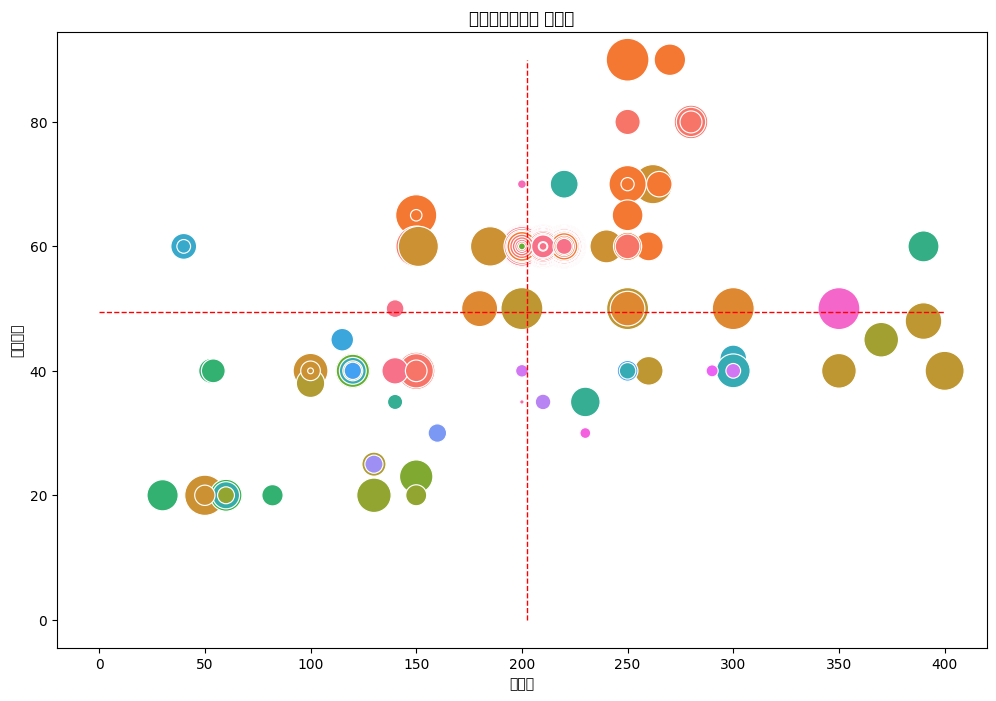

In [155]:
# 청소기 성능 시각화
plt.figure(figsize = (12, 8))
plt.title("핸디스틱청소기 성능표")
sns.scatterplot(x = '흡입력', y = '사용시간', size = '가격', hue = chart_data['회사명'],
               data = chart_data, sizes = (10, 1000), legend = False)
plt.plot([0, suction_max_value], [use_time_mean_value, use_time_mean_value], 'r--', lw = 1)
plt.plot([suction_mean_value, suction_mean_value], [0, use_time_max_value], 'r--', lw = 1)

for index, row in condition_data.iterrow():
    x = row['흡입력']
    y = row['사용시간']
    s = row['제품'].split(' ')[0]
    plt.text(x, y, s, size=10)
plt.show()